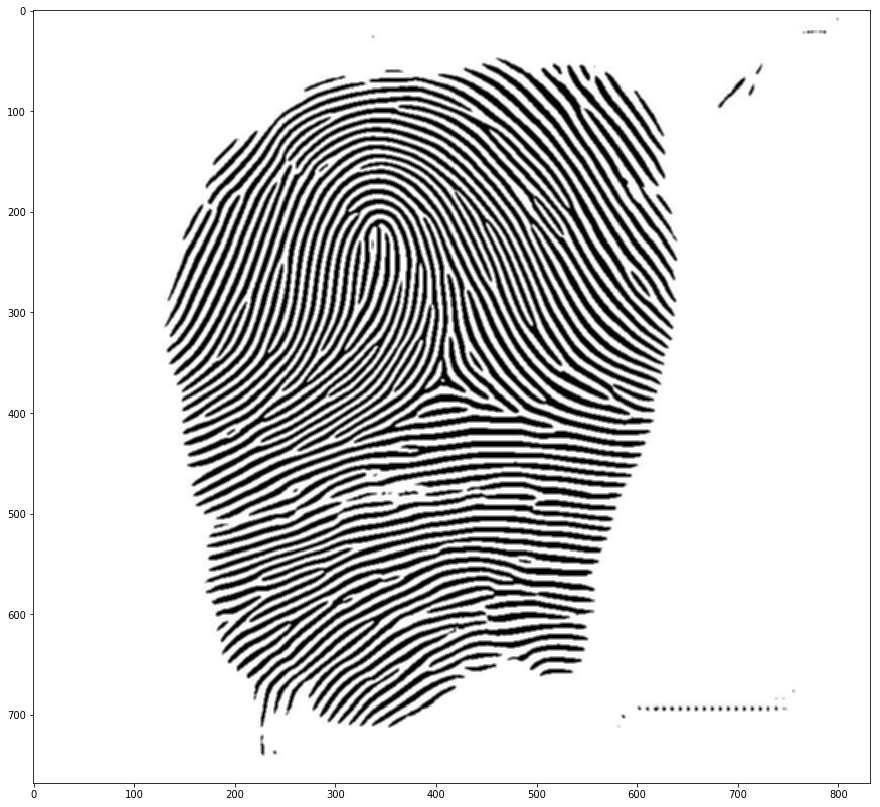

In [2]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt

import sys
sys.path.insert(1, 'E:\KSIP\LatentFingerPrintEnhancement\source')

from utilities import *
from fft import *
import math

img = cv.imread(r"E:\KSIP\Database\NIST14_Binary\F0000002.jpg",0)
img = cv.blur(img,(3,3))
rows, cols = img.shape

plt.figure(figsize = (15,15))
plt.imshow(img,cmap='gray')


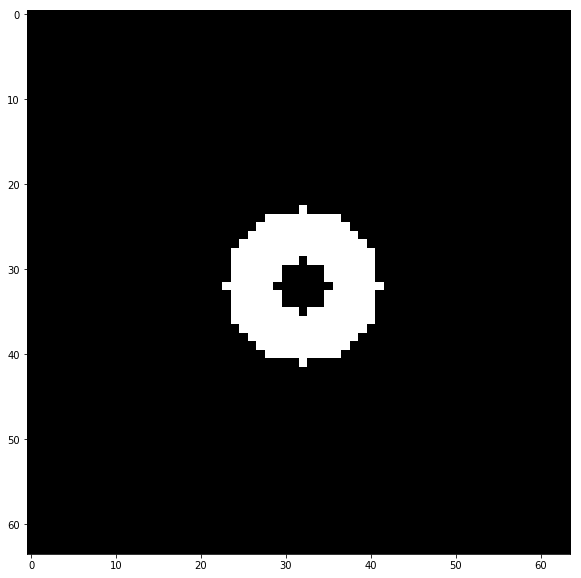

In [34]:
result_ff = np.ones((rows,cols),np.uint8)*255
result_of = np.ones((rows,cols),np.uint8)*255

kernel = 64
step = 16
# kernel = 32
# step = 8

cir1 = np.zeros((kernel,kernel),np.uint8)
cir2 = np.zeros((kernel,kernel),np.uint8)

cv.circle(cir1,(kernel//2,kernel//2),3,(255,255,255),-1)
cv.circle(cir2,(kernel//2,kernel//2),9,(255,255,255),-1)

bandpass = cir2 - cir1
plt.figure(figsize = (10,10))
plt.imshow(bandpass,cmap='gray')



In [22]:
for r in range(kernel//2,rows-kernel//2,step):
    for c in range(kernel//2,cols-kernel//2,step):
        roi = img[r-kernel//2:r+kernel//2, c-kernel//2:c+kernel//2].copy()
        spectrum = spatial2freq(roi)
        magnitude = get_magnitude(spectrum)

        # zero mean - In OpenCV, DC is maximum value of image
        magnitude = magnitude - magnitude.max()
        magnitude = np.abs(magnitude)
        magnitude[kernel//2,kernel//2] = magnitude.max()
        
        # Invert peak to maximum value        
        magnitude = 255-normalize(magnitude)
        y,x = np.where(magnitude==magnitude.max())
        
        # Bandpass Filter   
        magnitude = cv.bitwise_and(magnitude,magnitude,mask=bandpass)
        
        
        # Find two peaks of spectrum magnitude         
        if len(x) >= 2:
#             print("point max",x,y)
            

            p1 = x[0],y[0]
            p2 = x[1],y[1]

            # Estimate Frequency 
            freq1 = np.sqrt((p1[0]-kernel//2)**2+(p1[1]-kernel//2)**2)
            freq2 = np.sqrt((p2[0]-kernel//2)**2+(p2[1]-kernel//2)**2)
            freq = np.mean([freq1,freq2])
            
            # Create Frequency Field
            result_ff[r-step//2:r+step//2, c-step//2:c+step//2] = int(255*freq/64.)

#             print("frequency",freq)
          
            # Estimate Orientation
            angle = np.arctan2(-(p1[1]-p2[1]),p1[0]-p2[0]) 
            
#             print("original angle",angle,np.rad2deg(angle))

            # shift orientation +90 degrees 
            angle += np.pi/2
            
            # angle greater than pi
            if angle > np.pi:   
                angle = -2*np.pi + angle  
          
            # print("angle",np.rad2deg(angle))


            # Calculate Quadrant
            if -np.pi/2 <= angle <= np.pi/2:
                x_sign = 1
            else:
                x_sign = -1
            
            if -np.pi <= angle <= 0:
                y_sign = 1
            else:
                y_sign = -1

            
            # Create Orientation Field             
            x1,y1 = c,r

            x2 = x1 + x_sign * step / 2 * abs(np.cos(angle))
            y2 = y1 + y_sign * step/2*abs(np.sin(angle))
            
            x2,y2 = int(math.ceil(x2)),int(math.ceil(y2))
            x1,y1 = int(math.ceil(x1)),int(math.ceil(y1))

            cv.line(result_of,(x1,y1),(x2,y2),(0,0,255),1)

E:\KSIP\LatentFingerPrintEnhancement\source\utilities.py:58: RuntimeWarning: invalid value encountered in true_divide
  result = 255.*(image - image.min())/(image.max()-image.min())


In [23]:
cv.imwrite("./of.jpg",result_of)
cv.imwrite("./ff.jpg",result_ff)

True

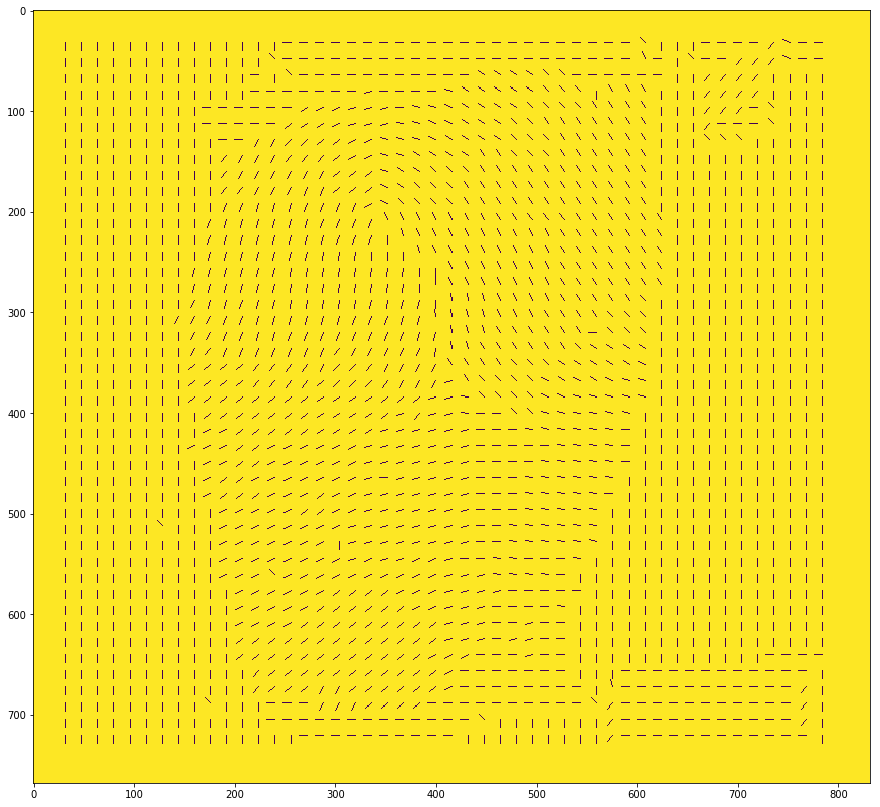

In [33]:
plt.figure(figsize = (15,15))
plt.imshow(result_of)

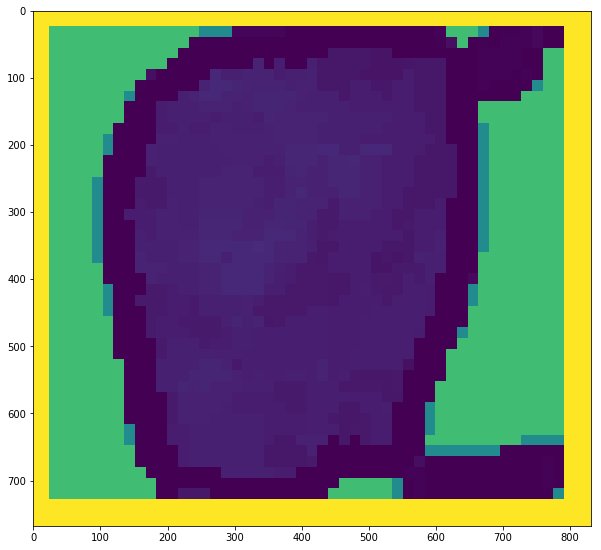

In [31]:
plt.figure(figsize = (10,10))
plt.imshow(result_ff)